In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import Normalizer
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import statistics
from sklearn import preprocessing

In [2]:
!pip3 install uci-dataset
from sklearn import datasets
import uci_dataset as dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
def plot_confusion(y_test, y_pred):
  mat = confusion_matrix(y_test, y_pred)
  plt.subplots(figsize=(12,8))
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label')


In [4]:
#1 Normal KNN
def normalKNN(trainX, testX, trainY, testY):
  model = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree')
  model.fit(trainX, trainY)
  predicted = model.predict(testX)
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
  return predicted

Leave-one-out cross validation is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set. That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point

In [5]:
#2 Local Unrestricted KNN
def getValidk(trainX,trainY):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  validK = []
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    validSampleK = []
    for k in range(2, 30):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:   
            validSampleK.append(k)
    validK.append(validSampleK)
  validK = np.array(validK)
  return validK

def getPreTrainedModels(trainX, trainY):
  trainedModels = []
  for i in range(2, 30):
    model = KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree')
    model.fit(trainX, trainY)
    trainedModels.append(model)
  return trainedModels    

def getPrediction(validK, trainedModels, M, trainX, testX, trainY):
  finalPredictions = []
  unique_k = set()
  for i in range(0, len(testX)):
    distances = []
    for j in range(0, len(trainX)):
        distances.append(np.linalg.norm(testX[i] - trainX[j]))
    distances = np.array(distances)
    indices = np.argsort(distances)
    nebrIndices = indices[0:M]
    nebrLabels = trainY[nebrIndices]

    kCorrectClassified = np.zeros(30)
    for ind in indices:
        kcurrArray = validK[ind]
        for z in range(len(kcurrArray)):
            k = kcurrArray[z]
            kCorrectClassified[k] += 1
    kbest = np.argmax(kCorrectClassified)
    unique_k.add(kbest)
    predictedClass = trainedModels[kbest - 2].predict(testX[i].reshape(1, -1))
    finalPredictions.append(predictedClass)
  return finalPredictions,unique_k

def localUnrestrictedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX,trainY)
  trainedModels = getPreTrainedModels(trainX, trainY)
  predicted ,uniquek = getPrediction(validK, trainedModels, M, trainX, testX, trainY)
  print("mean k values = ",statistics.mean(uniquek) )
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted)) 
  return predicted,uniquek

In [6]:
#3 Pruned KNN

def prunedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX,trainY)
  finalK = []
  for lst in validK:
    finalK = finalK + lst
  freq = np.bincount(np.array(finalK))
  print(freq, finalK)
  plt.plot(freq)

  L = 114
  array_list = []
  for m in range(len(validK)):
    array_list.append(np.array(validK[m]))

  validK = array_list
  arr = np.array(validK)
  freq_to_prune = []

  for i in range(len(freq)):
    if(freq[i] < L):
      freq_to_prune.append(i)

  for i in range(arr.shape[0]):
      for j in freq_to_prune:
        if j in arr[i] and arr[i].shape[0] != 1:
          arr[i] = np.delete(arr[i], np.where(arr[i] == j))
  print(arr)

In [7]:
#4 KNN One Per Class
def k_one_per_class(trainX,trainY):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  unique_class = np.unique(trainY)
  k_for_each_class = {}
  for i in unique_class:
    k_for_each_class[i] = [0 for i in range(2,30)]
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    for k in range(2, 30):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:
          k_for_each_class[testLabel[0]][k-2] += 1
        
  k_assigned_for_each_class = {}
  for i in unique_class:
    k_assigned_for_each_class[i] = np.argmax(k_for_each_class[i])+2
  return k_assigned_for_each_class

def localKNNoneperclass(trainX, testX, trainY, testY):
  unique_k =set()
  k_assigned_for_each_class = k_one_per_class(trainX,trainY)
  predicted = []
  for i in range(0, len(testX)):
    distances = []
    for j in range(0, len(trainX)):
        distances.append(np.linalg.norm(testX[i] - trainX[j]))
    distances = np.array(distances)
    indices = np.argsort(distances)
    percent_of_classification_as_class = {}
    for x in k_assigned_for_each_class:
      k = k_assigned_for_each_class[x]
      unique_k.add(k)
      nebrIndices = indices[0:k]
      nebrLabels = trainY[nebrIndices]
      percent_of_classification_as_class[x] = np.count_nonzero(nebrLabels == x)/k
    predicted.append(max(percent_of_classification_as_class, key=percent_of_classification_as_class.get))
  print("mean k values = ",statistics.mean(unique_k) )
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
  return predicted,unique_k
 

In [8]:
#4 KNN One Per Cluster
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

def getK(trainX):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(2,100), metric='silhouette', timings=False)
  visualizer.fit(trainX)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure
  kAtElbow = visualizer.elbow_value_
  return kAtElbow



def k_one_per_cluster(trainX, trainY, testX, testY):
    
    # bestK = getK(trainX)
    bestK = 9
    kmeans = KMeans(n_clusters=bestK, random_state=0).fit(trainX)
    labels = kmeans.labels_
    k_for_each_cluster = {}
    for i in np.unique(labels):
      k_for_each_cluster[i] = [0 for i in range(2,30)]
    
    validK = getValidk(trainX, trainY) 
    for i in range(len(validK)):
      #print(validK[i],labels[i]) 
      for j in range(len(validK[i])):
        k_for_each_cluster[labels[i]][validK[i][j]-2] += 1
    k_assigned_for_each_cluster = {}
    for i in np.unique(labels):
      k_assigned_for_each_cluster[i] = np.argmax(k_for_each_cluster[i])+2
    return k_assigned_for_each_cluster, labels , kmeans

def localKNNonepercluster(trainX,testX, trainY, testY):
  uniquek = set()
  models = getPreTrainedModels(trainX, trainY)
  k_assigned_for_each_cluster, labels ,kmeans = k_one_per_cluster(trainX, trainY, testX, testY)
  predicted = []
  for i in range(0, len(testX)):
    cluster_predicted = kmeans.predict(testX[i].reshape(1, -1))

    #print(k_assigned_for_each_cluster)
    
    bestk = k_assigned_for_each_cluster[cluster_predicted[0]]
    print(bestk)
    uniquek.add(bestk)
    model = models[bestk-2]
    predicted.append(model.predict(testX[i].reshape(1, -1)))
  print("mean k values = ",statistics.mean(uniquek) )
  print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
  return predicted,uniquek
  






In [9]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
  data = pd.read_csv(full_path, header=None)
  print(data.head())
  data.dropna()
  data = data[(data != '?').all(axis=1)]
	# retrieve numpy array
  data = data.values
	# split into input and output elements
  X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
  y = preprocessing.LabelEncoder().fit_transform(y)
  return X, y

--2022-12-01 14:00:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K   109KB/s    in 0.2s    

2022-12-01 14:00:43 (109 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]



In [10]:
def get_dataset(dataset):
  X = dataset.data
  y = dataset.target
  return X, y

# iris
#X, y = get_dataset(datasets.load_iris())

# glass
X,y = load_dataset("processed.cleveland.data")
# wine
# X, y = get_dataset(datasets.load_wine())



#X, y = get_dataset(dataset.load)
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)

normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)

     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


5


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


4


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


5


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


3


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


4


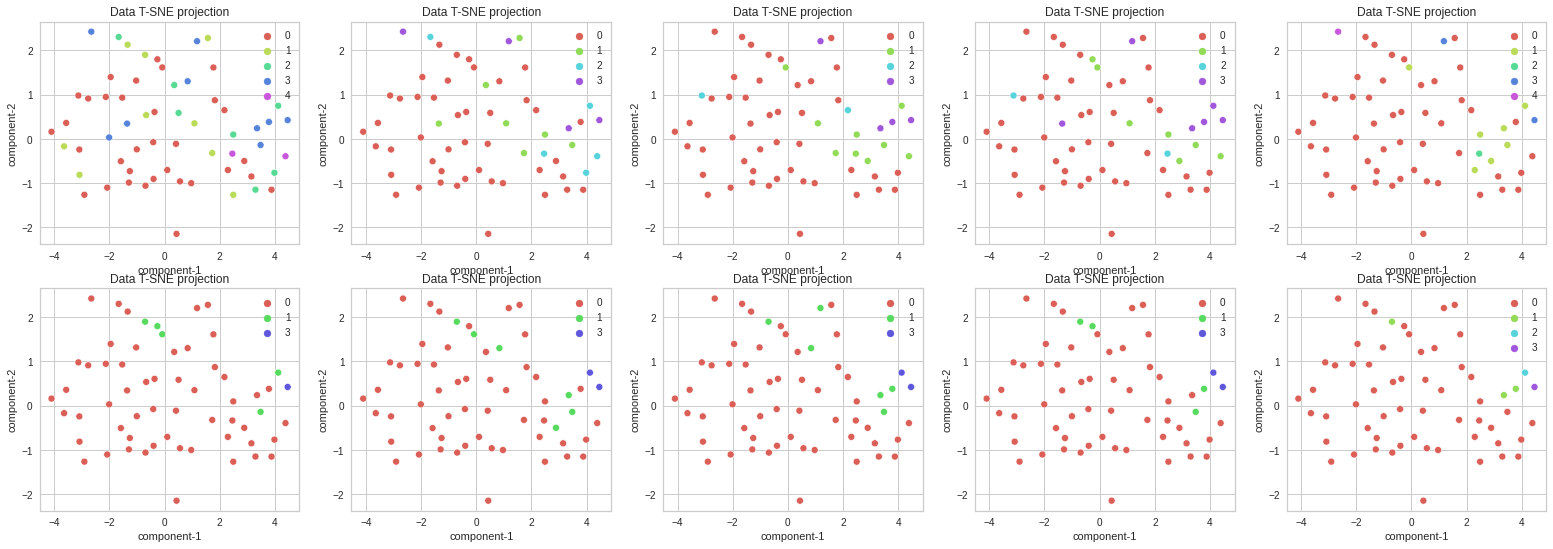

In [11]:
figure = plt.figure(figsize=(27, 9))

def plot_data(trainX, trainy):
    x = trainX.reshape(trainX.shape[0], -1)
    tsne = TSNE(n_components=2, random_state=1, learning_rate="auto",init="pca")
    z = tsne.fit_transform(x)

    df = pd.DataFrame()
    df["y"] = trainy
    df["component-1"] = z[:, 0]
    df["component-2"] = z[:, 1]
    print(len(np.unique(trainy)))
    sns.scatterplot(
        x="component-1",
        y="component-2",
        hue=df.y.tolist(),
        palette=sns.color_palette("hls", len(np.unique(trainy))),
        data=df,
    ).set(title="Data T-SNE projection")


for i in range(1,11):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(normalized_x_train,trainY)
    ax = figure.add_subplot(2,5, i)
    pred_i = knn.predict(normalized_x_test)
    plot_data(normalized_x_test, pred_i)

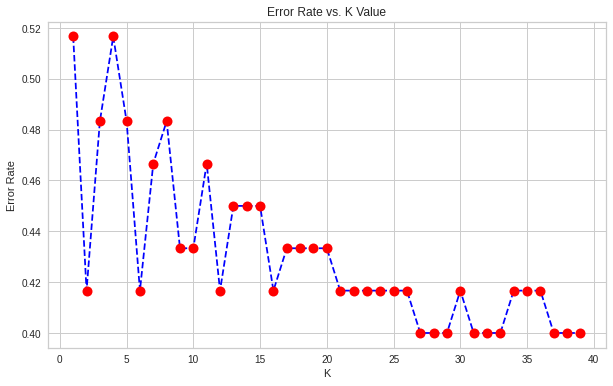

In [12]:
error_rate=[]
for i in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(normalized_x_train,trainY)
    pred_i = knn.predict(normalized_x_test)
    error_rate.append(np.mean(pred_i != testY))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');


In [13]:
predicted = normalKNN(normalized_x_train, normalized_x_test, trainY, testY)

Accuracy Score =  0.5166666666666667


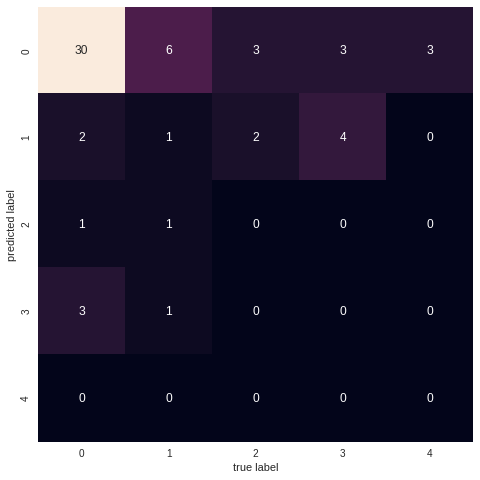

In [14]:
plot_confusion( testY,predicted)

In [15]:
predicted,uniqueks = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, 2)

<ipython-input-5-098ea8838e3d>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validK = np.array(validK)


mean k values =  29
Accuracy Score =  0.6


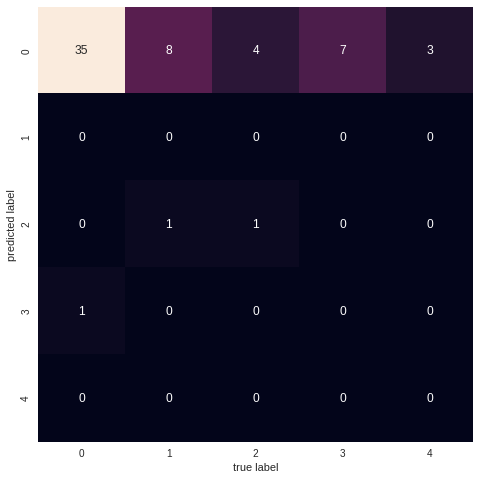

In [16]:
plot_confusion( testY,predicted)

In [17]:
predicted,uniqueks = localKNNoneperclass(normalized_x_train, normalized_x_test, trainY, testY)

mean k values =  17
Accuracy Score =  0.55


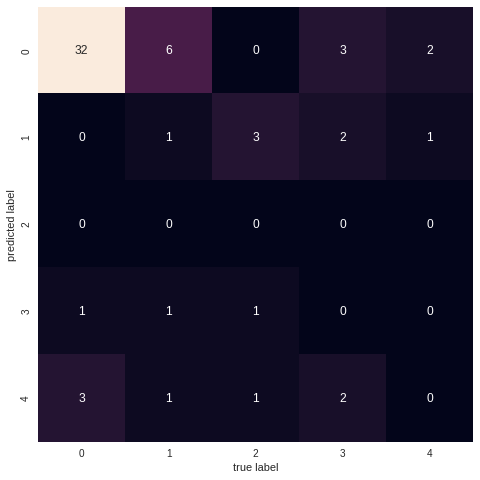

In [18]:
plot_confusion( testY,predicted)

<ipython-input-5-098ea8838e3d>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validK = np.array(validK)
<ipython-input-6-c9a5108ac7b1>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(validK)


[  0   0 121 112 111 113 111 111 109 116 110 111 113 116 118 120 118 122
 120 124 122 119 120 122 122 124 124 126 126 128] [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 15, 16, 17, 18, 19, 20, 2, 3, 4, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 23, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 4, 5, 6, 7, 8, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 3,

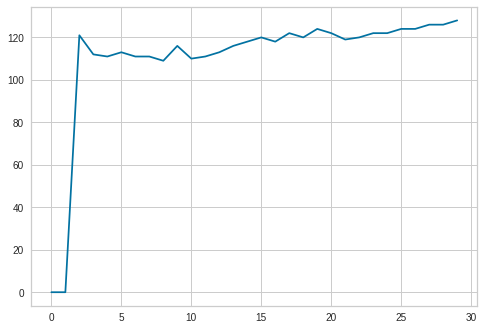

In [19]:
predicted = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, 2)

In [20]:
plot_confusion( testY,predicted)

ValueError: ignored

In [21]:
predicted,uniqueks = localKNNonepercluster(normalized_x_train, normalized_x_test, trainY, testY)

<ipython-input-5-098ea8838e3d>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validK = np.array(validK)


2
2
2
2
2
2
2
2
9
9
9
2
2
2
5
2
2
9
9
2
2
2
2
9
9
5
12
5
9
2
2
2
9
2
2
2
5
2
2
5
2
2
29
9
5
2
2
12
2
2
5
2
5
9
2
12
2
5
5
12
mean k values =  11
Accuracy Score =  0.5666666666666667


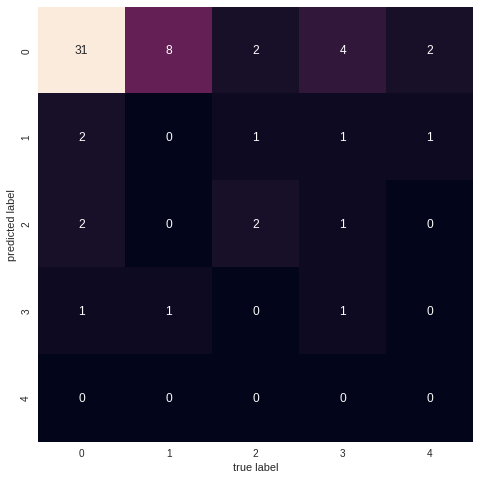

In [22]:
plot_confusion( testY,predicted)